#  ALIGNING IRIS IMAGES USING SDO IMAGES/AIA_304
## IMPORTANT: READ THE BELOW TEXT 

In this program the IRIS images were aligned using the AIA_304 images. For this, the IRIS images were brought to the same resolution as the AIA_304 images, the same observation window was selected which coincided with the ALMA observation window, that is, the data in which the three telescopes (SDO,IRIS,ALMA) had co-observation were selected.  Then, the AIA_304 and IRIS images were averaged, interpolated so that both had the same scale, and then the SDO field of view was windowed with the IRIS field of view while analyzing the symmetry. 
NOTE: 
1- THE SDO FIELD OF VIEW MUST BE LARGER THAN THE AIA_304 FIELD OF VIEW IN ORDER FOR THE PROGRAM TO TRANSLATE THE IRIS OBSERVATION SALE INTO THE AIA_304 FIELD OF VIEW.
1- THE DATA OF IRIS-2796 AND AIA 304 WERE CHOSEN TO MAKE THE ALIGNMENT BECAUSE ACCORDING TO THE VAL MODE BOTH LINES ARE FORMED IN THE TRANSITION REGION.
SEE: 
https://ui.adsabs.harvard.edu/abs/1981ApJS...45..635V/abstract (Figure 1)
and https://iris.lmsal.com/itn39/Mg_diagnostics.html
where you can find information about line formation in the solar atmosphere. 

In [1]:
import sunpy.data.sample
from skimage.transform import rescale
from skimage.metrics import structural_similarity as ssim
from astropy.coordinates import EarthLocation, SkyCoord
from datetime import date, datetime, timedelta
import sunpy.visualization.colormaps as cm
from sunpy.net import Fido, attrs as SAF
from scipy.stats.stats import pearsonr
#from iris_lmsalpy import hcr2fits
import matplotlib.pyplot as plt
from useful_functions import *  #file where is some usefulls functions 
import scipy.ndimage as scnd
from astropy.io import fits
import astropy.units as u
from tqdm import tqdm
import numpy as np
import sunpy.map
import warnings
import salat
import glob
warnings.filterwarnings("ignore")


/tmp/ipykernel_112267/2793220591.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [2]:
path_ALMA='/media/javier/SSD_2/D06_region/datos_SDO-completos_IRIS_ALMA/ALMA_data/{}'
file=path_ALMA.format('D06_solaralma.b3.fba.20180412_155228-162441.2017.1.00653.S.level4.k.fits')
almacube, header, timesec, timeutc, beammajor, beamminor, beamangle = salat.read(file,timeout=True,beamout=True,
                                                                                 HEADER=True,SILENT=False,fillNan=True)


---------------------------------------------------
--------------- SALAT READ part of ----------------
-- Solar Alma Library of Auxiliary Tools (SALAT) --

Reading ALMA cube



100%|████████████████████████████████████| 1608/1608 [00:00<00:00, 41431.59it/s]


Do you want to fill NaN with data median? (y/n):  Y


---------------------------------------------------
--------------- SALAT INFO part of ----------------
-- Solar Alma Library of Auxiliary Tools (SALAT) --


----------------------------------------------
| Data feat.: 
----------------------------------------------
|  ALMA BAND:  3
|  Obs. Date:  2018-04-12
|  ALMA proj:  2017.1.00653.S
|  Pix. Unit:  K
|  Pix. Size:  0.3  arcsec.
|  Beam mean:  2.15798  arcsec
|  FOV. diam:  notcomputed
----------------------------------------------
| Data range 
----------------------------------------------
|  Min =  5260.81054688  Kelvin
|  Max =  10677.8203125  Kelvin
----------------------------------------------

Done!


In [3]:
def aligning_IRIS_with_SDO(sdo_file, iris_data, time_vec_iris,time_vec_sdo,time_vec_ALMA ,path_img_crop):
    """
    This function allows us to find a pixel reference in IRIS images to one snapshot(Photogram)
    to do an alignment of IRIS'S image with SDO'S Images
    For this, the SIMM and Pearson method was used to analyze correlations
    --------------------Input----------------------------------
    Parameters:
               sdo_file:      vector with the frames taken by the SDO/AIA. Its format is .npy 
                              and it was created using the program "funtion_to_create_data_SDO_cube.ipynb"     
               iris_data:     FILE .FITS obtained from IRIS database
               
               time_vec_iris: vector where its components are timeutc of every snapshot (photogram) 
                              of IRIS data cube. The Fortmat of time_vec_iris's components is datetime.datetime, for example
                              one of  time_vec_iris's components look like should be 
                              datetime.datetime(2018, 4, 12, 15, 52, 31, 992187) 
                              THIS VECTOR WAS  BUILT USING THE FUNCTION "creating_time_vector"
                              which goes into more detail
                              
               time_vec_sdo:  vector where its components are timeutc of every snapshot (photogram) 
                              of SDO data cube. The Fortmat of time_vec_sdo's components is datetime.datetime, for example
                              one of  time_vec_sdo's components look like should be 
                              datetime.datetime(2018, 4, 12, 15, 52, 31, 992187)
                              THIS VECTOR WAS BUILT WITH THE PROGRAM "funtion_to_create_data_SDO_cube.ipynb"

               time_vec_ALMA: vector where its components are timeutc of every snapshot (photogram) 
                              of SDO data cube. The Fortmat of time_vec_ALMA's components is datetime.datetime, for example
                              one of  time_vec_ALMA's components look like should be 
                              datetime.datetime(2018, 4, 12, 15, 52, 31, 992187)
                              THIS VECTOR TAKEN FROM  SALAT DATA BASE 
                              
               path_img_crop:
    --------------------Input----------------------------------
    Estimated heliprojective coordinates for the center of the 
    IRIS matrix estimated using the SIMM and PEARSON method
    
    """
    url                 = sorted(glob.glob(path_img_crop))
    sdo_resolution      = fits.open(url[0])[0].header['CDELT2']
    iris_resolution     = iris_data[0].header['CDELT1']
    scale_factor        = iris_resolution/ sdo_resolution
    iris_cube           = iris_data[0].data
    print('scale_factor:', scale_factor)
    print('Rescaling IRIS  images')
    
    rescaled_iris       = []
    for i in tqdm(range(len(iris_cube)), colour='green'):
        rescaled_iris.append(rescale(iris_cube[i], scale_factor, order=0,
                                    anti_aliasing=False, preserve_range=True))
    rescaled_iris       = np.array(rescaled_iris)

    print('________________________________________________________________________')
    print('initial shape:'   , sdo_file.shape,
          '| rescaled shape:', rescaled_iris.shape)

    # -------------------Selecting the same windown of ALMA----------------
    posicion_n_0_sdo, posicion_n_f_sdo   = find_nearest(time_vec_sdo , time_vec_ALMA[0], time_vec_ALMA[-1],'SDO', 'ALMA')
    posicion_n_0_iris, posicion_n_f_iris = find_nearest(time_vec_iris, time_vec_ALMA[0], time_vec_ALMA[-1],'IRIS', 'ALMA')
    
    mean_sdo    = np.sum([i for i in sdo_file[int(posicion_n_0_sdo):int(posicion_n_f_sdo)]], 0)/len(sdo_file[int(posicion_n_0_sdo):int(posicion_n_f_sdo)])
    mean_iris   = np.sum([i for i in rescaled_iris[int(posicion_n_0_iris):int(posicion_n_f_iris)]],0)/len(rescaled_iris[int(posicion_n_0_iris):int(posicion_n_f_iris)])

    sdo_interp  = np.interp(mean_sdo, (np.percentile(mean_sdo, 11), np.percentile(mean_sdo, 95)), (0, +1))
    iris_interp = np.interp(mean_iris, (np.percentile(mean_iris, 11), np.percentile(mean_iris, 95)), (0, +1))
    
    
    # -----------------------ALMA_VECTOR---------------------------------------
    flatten_iris = iris_interp.flatten()
    ccrr_pearson = np.zeros((sdo_interp.shape[0], sdo_interp.shape[1]))
    ccrr_ssim    = np.zeros((sdo_interp.shape[0], sdo_interp.shape[1]))
    print('|----Estimating Pearson and SSIM coeffients---- | ')
    for i in tqdm(range(0, sdo_interp.shape[0]-iris_interp.shape[0]+1, 1), position=0, desc="i", leave=False, colour='green', ncols=100):
        for j in range(0, sdo_interp.shape[1] - iris_interp.shape[1]+1, 1):
            matrix = sdo_interp[0+i:iris_interp.shape[0]+i, 0+j:iris_interp.shape[1]+j].copy()
            corr, valor_p = pearsonr(matrix.flatten(), flatten_iris)
            ssim_none = ssim(matrix, iris_interp,
                             data_range=sdo_interp.max() - sdo_interp.min())
            x = i+iris_interp.shape[1]//2
            y = j+iris_interp.shape[0]//2
            ccrr_pearson[x][y] = corr
            ccrr_ssim[x][y]    = ssim_none

    x_max_pearson = np.where(ccrr_pearson == np.max(ccrr_pearson))[1][0]
    y_max_pearson = np.where(ccrr_pearson == np.max(ccrr_pearson))[0][0]
    x_max_ssim    = np.where(ccrr_ssim    == np.max(ccrr_ssim))[1][0]
    y_max_ssim    = np.where(ccrr_ssim    == np.max(ccrr_ssim))[0][0]

    print('________________________________________________________________________')
    print('x_max_pearson=', x_max_pearson, '| y_max_pearson=',
          y_max_pearson, "| r=", np.max(ccrr_pearson))

    
    print('________________________________________________________________________')
    print('x_max_ssim   =', x_max_ssim, '| y_max_ssim   =',
          y_max_ssim,   "| r=", np.max(ccrr_ssim))

    map_sunpy                            = sunpy.map.Map(url[posicion_n_0_sdo])
    x_scaled_pearson , y_scaled_pearson  = x_max_pearson,  y_max_pearson
    cord_pearson                         = map_sunpy.pixel_to_world(x_scaled_pearson *u.pix,  y_scaled_pearson *u.pix )
    print('Pearson: (Tx, Ty) in arcsec',cord_pearson.Tx.value,cord_pearson.Ty.value)
 
    print('________________________________________________________________________')
    x_scaled_ssim, y_scaled_ssim =  x_max_ssim   ,  y_max_ssim
    cord_ssim                    = map_sunpy.pixel_to_world(x_scaled_ssim*u.pix,  y_scaled_ssim*u.pix )
    print('SSIM   : (Tx, Ty) in arcsec',cord_ssim.Tx.value,cord_ssim.Ty.value)

In [4]:
path_iris     = '/media/javier/SSD_2/D06_region/datos_SDO-completos_IRIS_ALMA/IRIS_data/{}'
iris_2796     = fits.open(path_iris.format('iris_l2_20180412_130937_3640258010_SJI_2796_t000.fits'))
time_vec_iris = creating_time_vector(iris_2796)
#--------------------------------------------------------------------------------------------------------
path_sdo       = '/home/javier/Documents/MSc-program/SDO_DATA_ALIGNIING/SDO_data_crop_and_rotate/{}'
data_aia_304   = np.load(path_sdo.format('crop_and_rotate_AIA304.npy'), allow_pickle=True)
time_304       = np.load(path_sdo.format('cuboAIA_timeUTC_AIA304.npy'), allow_pickle=True)

In [5]:
path_img_crop = '/home/javier/Documents/MSc-program/SDO_DATA_ALIGNIING/SDO/304/crop_and_rotate/*.fits'
aligning_IRIS_with_SDO(data_aia_304, iris_2796, time_vec_iris, time_304, timeutc,path_img_crop)

scale_factor: 0.2771737772112669
Rescaling IRIS  images


100%|████████████████████████████████████████| 950/950 [00:01<00:00, 860.95it/s]


________________________________________________________________________
initial shape: (275, 471, 470) | rescaled shape: (950, 215, 204)
______________________________________________________
t_0_SDO = 2018-04-12 15:52:29.140000
t_0_ALMA= 2018-04-12 15:52:31.992187
______________________________________________________
t_f_SDO = 2018-04-12 16:24:41.120000
t_0_ALMA= 2018-04-12 16:24:40.246093
______________________________________________________
posicion_n_0: 85 | posicion_n_f: 246
______________________________________________________
______________________________________________________
t_0_IRIS = 2018-04-12 15:52:18.956000
t_0_ALMA= 2018-04-12 15:52:31.992187
______________________________________________________
t_f_IRIS = 2018-04-12 16:24:43.844000
t_0_ALMA= 2018-04-12 16:24:40.246093
______________________________________________________
posicion_n_0: 266 | posicion_n_f: 319
______________________________________________________
|----Estimating Pearson and SSIM coeffients---- |

                                                                                                    1.46s/it]

________________________________________________________________________
x_max_pearson= 226 | y_max_pearson= 240 | r= 0.4246136255937487
________________________________________________________________________
x_max_ssim   = 225 | y_max_ssim   = 239 | r= 0.10615841660796883
Pearson: (Tx, Ty) in arcsec -133.01634556381032 -396.8174617422354
________________________________________________________________________
SSIM   : (Tx, Ty) in arcsec -133.61651031300426 -397.4176236454267


## This part of program we gonna  do a plot to see our alignment

In [9]:
# --------------Selecting the same windown of ALMA----------------
posicion_n_0_sdo , posicion_n_f_sdo  = find_nearest(time_304     , timeutc[0], timeutc[-1], 'AIA_304', 'ALMA'   )
posicion_n_0_iris, posicion_n_f_iris = find_nearest(time_vec_iris, timeutc[0], timeutc[-1], 'IRIS_2769' , 'ALMA')

rescaled_iris = iris_rescale(iris_2796,0.600165)
path_img_crop =  '/home/javier/Documents/MSc-program/SDO_DATA_ALIGNIING/SDO/304/crop_and_rotate/*.fits'
url     = sorted(glob.glob(path_img_crop))


x_max_pearson , y_max_pearson  = 226,  240 # This values was taken from the 
x_max_ssim, y_max_ssim         = 225,  239 # aligning_IRIS_with_SDO's output 
posicion_n_0_sdo                  = 85     #

map_sunpy                      = sunpy.map.Map(url[posicion_n_0_sdo])
cord_pearson                   = map_sunpy.pixel_to_world(x_max_pearson *u.pix,  y_max_pearson *u.pix )
print('Pearson: (Tx, Ty) in arcsec',cord_pearson.Tx.value,cord_pearson.Ty.value)

print('________________________________________________________________________')
cord_ssim               = map_sunpy.pixel_to_world(x_max_ssim*u.pix,  y_max_ssim*u.pix )
print('SSIM   : (Tx, Ty) in arcsec',cord_ssim.Tx.value,cord_ssim.Ty.value)

Pearson: (Tx, Ty) in arcsec -133.01634556381032 -396.8174617422354
________________________________________________________________________
SSIM   : (Tx, Ty) in arcsec -133.61651031300426 -397.4176236454267


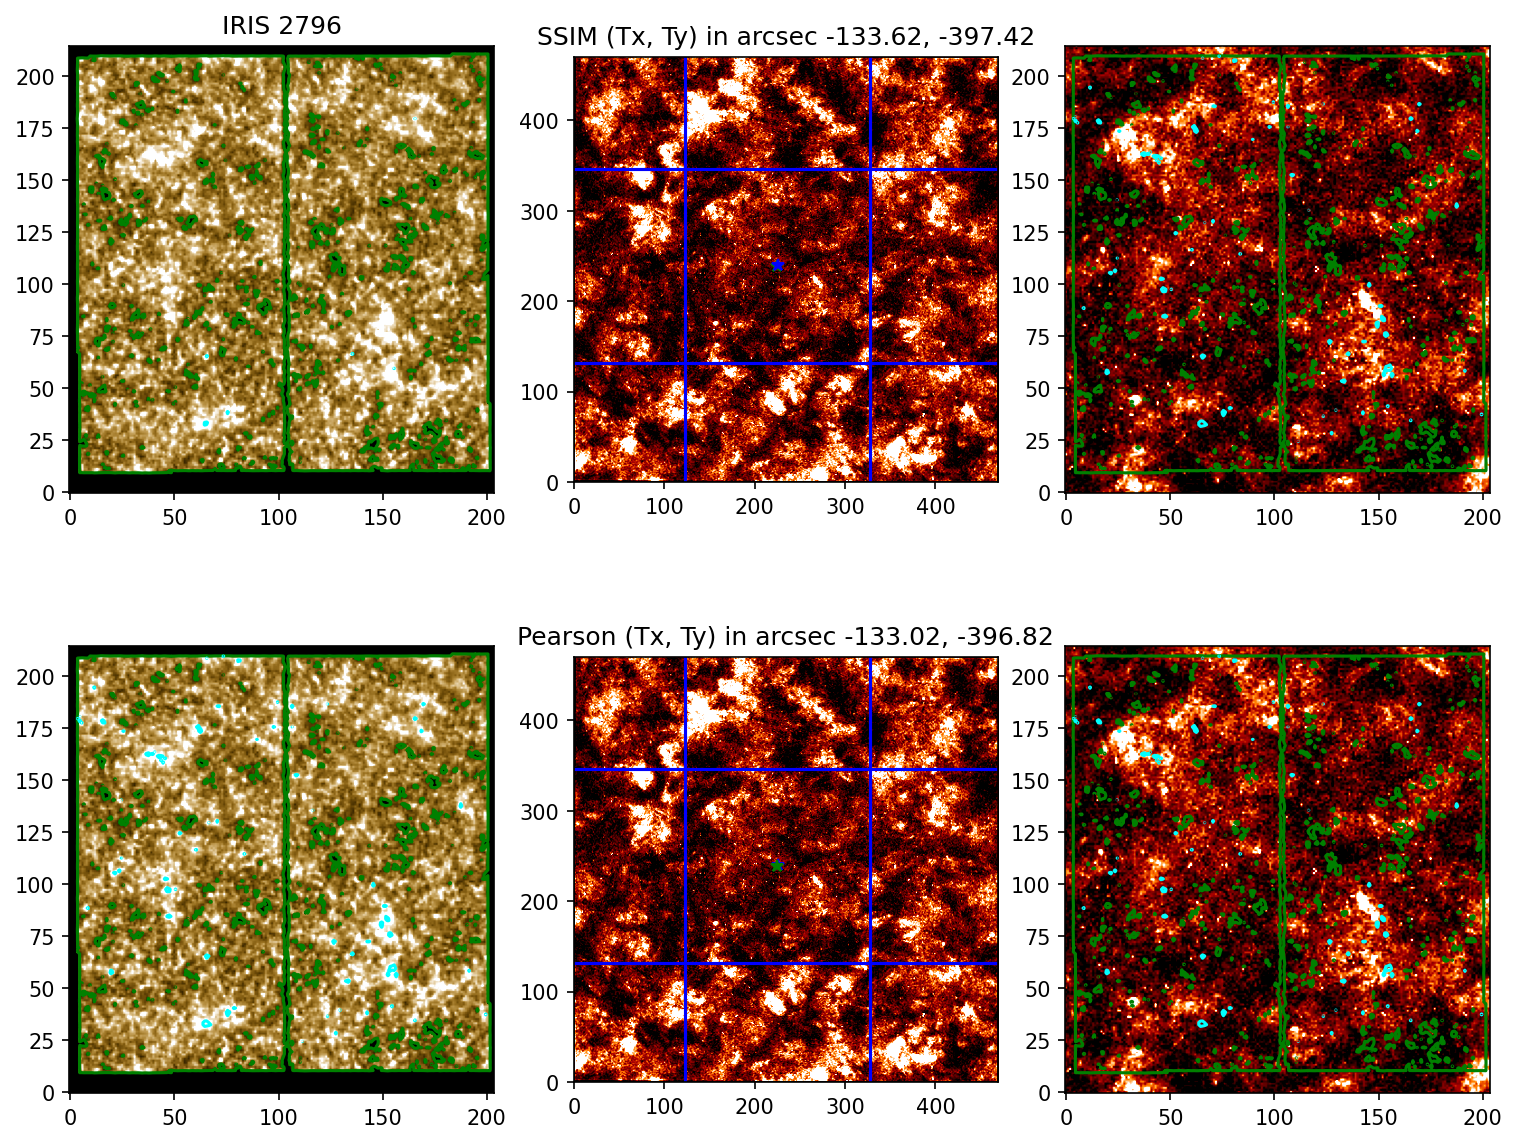

In [20]:
sdo_file=data_aia_304.copy()
vmin_2796, vmax_2796 = np.percentile(rescaled_iris,12), np.percentile(rescaled_iris,95) 
vmin_304,  vmax_304  = np.percentile(sdo_file,11)           , np.percentile(sdo_file,95) 

fig, ax=plt.subplots(figsize=(10,8), dpi=150, ncols=3, nrows=2, constrained_layout=True)
ax[0,0].set_title('IRIS 2796')
ax[0,0].imshow(rescaled_iris[posicion_n_0_iris],origin='lower',cmap='irissji2796', vmin=vmin_2796 , vmax=vmax_2796)
ax[0,0].contour(rescaled_iris[posicion_n_0_iris],origin='lower', levels=[50,150],colors=['green', 'cyan'])


ax[0,1].imshow(sdo_file[posicion_n_0_sdo],cmap='sdoaia304',origin='lower',vmin=vmin_304, vmax=vmax_304)
ax[0,1].plot(x_max_ssim,y_max_ssim,'g*')
ax[0,1].axvline(x = x_max_ssim+rescaled_iris.shape[2]/2, color = 'b')
ax[0,1].axvline(x = x_max_ssim-rescaled_iris.shape[2]/2, color = 'b')
ax[0,1].axhline(y = y_max_ssim+rescaled_iris.shape[1]/2,color = 'b')
ax[0,1].axhline(y = y_max_ssim-rescaled_iris.shape[1]/2, color = 'b')
ax[0,1].set_title('SSIM (Tx, Ty) in arcsec {x}, {y}'.format(x=round(cord_ssim.Tx.value,2), y=round(cord_ssim.Ty.value,2))) 
ax[0,1].plot(x_max_pearson,y_max_pearson,'b*')

x_max_sdo, y_max_sdo = x_max_ssim, y_max_ssim
y_new_i_sdo=int(y_max_sdo-rescaled_iris.shape[1]/2)
y_new_f_sdo=int(y_max_sdo+rescaled_iris.shape[1]/2)
x_new_i_sdo=int(x_max_sdo-rescaled_iris.shape[2]/2)
x_new_f_sdo=int(x_max_sdo+rescaled_iris.shape[2]/2)

ax[0,2].imshow(sdo_file[posicion_n_0_sdo][y_new_i_sdo:y_new_f_sdo, x_new_i_sdo:x_new_f_sdo],cmap='sdoaia304',origin='lower',vmin=vmin_304, vmax=vmax_304)
ax[0,2].contour(rescaled_iris[posicion_n_0_iris],origin='lower', levels=[50,120],colors=['green', 'cyan'])

ax[1,0].imshow(rescaled_iris[posicion_n_0_iris],origin='lower',cmap='irissji2796',vmin=vmin_2796 , vmax=vmax_2796)
ax[1,0].contour(rescaled_iris[posicion_n_0_iris],origin='lower', levels=[50,120],colors=['green', 'cyan'])



ax[1,1].set_title('Pearson (Tx, Ty) in arcsec {x}, {y}'.format(x=round(cord_pearson.Tx.value,2), y=round(cord_pearson.Ty.value,2))) 
ax[1,1].imshow(sdo_file[posicion_n_0_sdo],cmap='sdoaia304',origin='lower',vmin=vmin_304, vmax=vmax_304)
ax[1,1].plot(x_max_pearson,y_max_pearson,'b*')
ax[1,1].plot(x_max_ssim,y_max_ssim,'g*')
ax[1,1].axvline(x = x_max_ssim+rescaled_iris.shape[2]/2, color = 'b')
ax[1,1].axvline(x = x_max_ssim-rescaled_iris.shape[2]/2, color = 'b')
ax[1,1].axhline(y = y_max_ssim+rescaled_iris.shape[1]/2,color = 'b')
ax[1,1].axhline(y = y_max_ssim-rescaled_iris.shape[1]/2, color = 'b')


x_max_sdo, y_max_sdo = x_max_pearson, y_max_pearson
y_new_i_sdo=int(y_max_sdo-rescaled_iris.shape[1]/2)
y_new_f_sdo=int(y_max_sdo+rescaled_iris.shape[1]/2)
x_new_i_sdo=int(x_max_sdo-rescaled_iris.shape[2]/2)
x_new_f_sdo=int(x_max_sdo+rescaled_iris.shape[2]/2)

ax[1,2].imshow(sdo_file[posicion_n_0_sdo][y_new_i_sdo:y_new_f_sdo, x_new_i_sdo:x_new_f_sdo],cmap='sdoaia304',origin='lower',vmin=vmin_304, vmax=vmax_304)
ax[1,2].contour(rescaled_iris[posicion_n_0_iris],origin='lower', levels=[50,120],colors=['green', 'cyan'])